# AMG+ for 1D Helmholtz: 4/2 Repetitive Coarsening, 3-level
* Constant $k$. $k h$ designed so that wavelength evenly divides the domain.
* Discretization: 5-point (4th order).
* Kaczmarz relaxation.
* Fixed-domain problem; repetitive, so we sample windows from a test vector.
* Using ideal TVs.
* Interpolation LS fitting is weighted by $\|A x^{(k)}\|^{-1}$, where $k$ runs over test functions, and the norm is local (over 3 aggregates when fitting interpolation in an aggregate). This forces the interpolation row sums to be $1$, as the constant null-space vector has infinite LS weight. Thus $A^c$ is exactly singular and $b^c$ is exactly compatible with it at the coarse level in the cycle.

In [69]:
%run /Users/olivne/helmholtz/src/helmholtz/startup.ipy
import itertools
import helmholtz.analysis.plots

In [58]:
# Fixed seed for reproducible results.
np.random.seed(2)

# Domain size.
n = 96 # 192
domain_size = n   # With meshsize h = 1.
# Scaled wave number. Fit so lam_min = 0 (integer # periods in domain).
discretization = "5-point"
#kh = 0
kh = helmholtz.analysis.ideal.find_singular_kh(discretization, n)[0]
#kh = 0.5

repetitive = True

# Test vectors.
ideal_tv = False    # Use eigenvectors or not.
# Number of test vectors.  
num_examples = 4

# Set # sweeps manually here.
num_sweeps_on_vectors = 100 # None
threshold = 0.1

# Boottstrapping parameters.
interpolation_method = "ls" # "weighted_ls" #"ls"
fit_scheme = "ridge" #"plain"
weighted = False #True
neighborhood = "extended" #"aggregate" # "extended"
num_test_examples = 5
leeway_factor = 1.3

_LOGGER.info("kh {}".format(kh))

INFO     kh 0.5233853805513015


## Level 0->1 Coarsening

### Relaxation

INFO     Kaczmarz
INFO     Iter     |r|                         |x|         RER
INFO     0     1.239e+00                    4.469e-01    2.775
INFO     1     7.015e-01 (0.566) [0.566]    3.514e-01    2.002 (0.721)
INFO     2     4.137e-01 (0.590) [0.578]    3.063e-01    1.357 (0.678)
INFO     3     2.586e-01 (0.626) [0.594]    2.831e-01    0.919 (0.677)
INFO     4     1.786e-01 (0.691) [0.617]    2.696e-01    0.667 (0.726)
INFO     5     1.359e-01 (0.761) [0.643]    2.603e-01    0.526 (0.788)
INFO     6     1.114e-01 (0.819) [0.670]    2.533e-01    0.442 (0.842)
INFO     7     9.643e-02 (0.864) [0.695]    2.475e-01    0.391 (0.885)
INFO     8     8.616e-02 (0.893) [0.717]    2.426e-01    0.357 (0.911)
INFO     9     7.854e-02 (0.911) [0.736]    2.382e-01    0.331 (0.928)
INFO     10    7.285e-02 (0.927) [0.753]    2.343e-01    0.312 (0.943)
INFO     11    6.842e-02 (0.939) [0.769]    2.307e-01    0.297 (0.953)
INFO     12    6.482e-02 (0.947) [0.782]    2.274e-01    0.286 (0.961)
INFO 

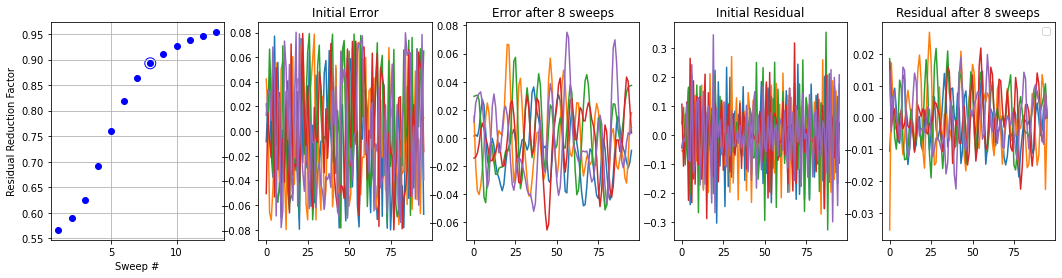

In [62]:
method_info = hm.solve.smoothing.check_relax_cycle_shrinkage(
    multilevel, num_levels=1, leeway_factor=leeway_factor, slow_conv_factor=0.95, num_examples=5)
num_sweeps = method_info["Kaczmarz"][1]

In [65]:
# Generate animation video of Kaczmarz shrinkage.
# factor, num_sweeps, residual, conv, rer, relax_conv_factor, x_history, r_history = method_info["Kaczmarz"]
# animation = helmholtz.analyis.plots.animate_shrinkage(factor, num_sweeps, residual, conv, rer, relax_conv_factor, x_history, r_history)
# animation.ipython_display(fps=10, loop=True, autoplay=True)
# animation.write_videofile("laplace_shrinkage.mp4", fps=num_frames // duration)
# animation.write_gif('kaczmarz_shrinkage.gif', fps=num_frames // duration)
# animation.write_gif('kaczmarz_shrinkage.gif', fps=num_frames // duration)

In [66]:
nu = num_sweeps_on_vectors if num_sweeps_on_vectors is not None else num_sweeps
# Generate initial test vectors.
level = multilevel[0]
if ideal_tv:
    _LOGGER.info("Generating {} ideal TVs".format(num_examples))
    x, lam = hm.analysis.ideal.ideal_tv(level.a, num_examples)
else:
    _LOGGER.info("Generating {} TVs with {} sweeps".format(num_examples, nu))
    x = hm.setup.auto_setup.get_test_matrix(a, nu, num_examples=num_examples)
    _LOGGER.info("RER {:.3f}".format(norm(level.a.dot(x)) / norm(x)))
x_log.append(x)

INFO     Generating 4 TVs with 100 sweeps
INFO     RER 0.118


### Coarsening: Fixed (4/2)

In [67]:
# Coarsening. Force 2 coarse vars per aggregate so we can test alignment.
aggregate_size = 4
num_components = 2

# Optimize aggregate_size, num_components using mock cycle rates.
# coarsener = hm.setup.coarsening_uniform.UniformCoarsener(
#     level, x, num_sweeps, repetitive=repetitive)
# info = coarsener.get_coarsening_info(1, fmt="dataframe")
# r, aggregate_size, nc, cr, mean_energy_error, mock_conv, mock_work, mock_efficiency = \
#     coarsener.get_optimal_coarsening(1)
# _LOGGER.info("R {} a {} nc {} cr {:.2f} mean_energy_error {:.4f}; mock cycle num_sweeps {} conv {:.2f} "
#              "eff {:.2f}".format(
#     r.shape, aggregate_size, nc, cr, mean_energy_error, num_sweeps, mock_conv, mock_efficiency))
# coarsener.get_coarsening_info(1, fmt="dataframe")

nu  30 s [1.    0.624 0.092 0.013] Energy error [0.533 0.078 0.011 0.   ]
INFO     Mock cycle conv [0.597 0.328 0.199 0.153 0.149 0.126 0.087 0.072 0.069 0.064 0.062]


,0,1,2,3
0,-0.4089,-0.5379,-0.5654,-0.4730
1,-0.7003,-0.2652,0.2431,0.6165


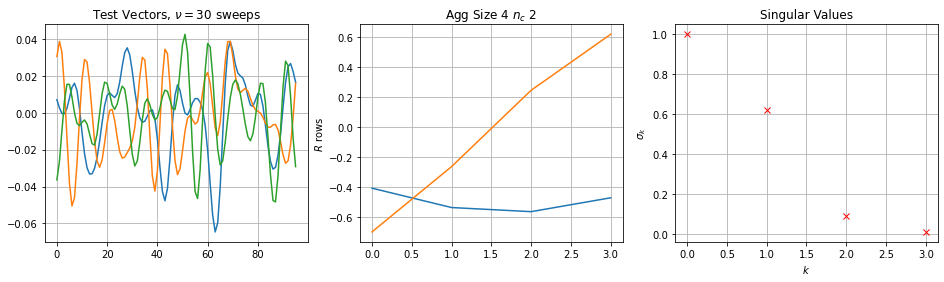

In [71]:
r = helmholtz.analysis.plots.plot_svd_coarsening_accuracy(level, 30, aggregate_size, num_components)
display(pd.DataFrame(r))

In [72]:
aggregate_size, num_components = 4, 2
r, s = hm.repetitive.locality.create_coarsening(x, aggregate_size, num_components, normalize=False)
R = r.tile(level.size // aggregate_size)
xc = R.dot(x)
# display(pd.DataFrame(R[:5,:10].todense()))
# hm.repetitive.locality.plot_coarsening(R, x)

### Local Mock Cycle (LMC) Rate
The mock cycle rate is calculated on a domain of size $4 a$, $a$ = aggregate size.

In [73]:
num_sweeps = max(num_sweeps, 7)

In [74]:
# Calculate local mock cycle convergence rate on a domain of size 4 * aggregate_size.
m = 5
nu_values = np.arange(1, num_sweeps + 1)
mock_conv = hm.repetitive.locality.mock_conv_factor_for_domain_size(kh, discretization, r, aggregate_size, m * aggregate_size, nu_values)
_LOGGER.info("Mock cycle conv |domain|={} {}".format(
    m * aggregate_size, np.array2string(mock_conv, precision=3)))

INFO     Mock cycle conv |domain|=20 [0.589 0.294 0.167 0.11  0.15  0.115 0.082 0.063]


### Interpolation $P = R^T$

In [75]:
# Initial guess for interpoation: P = R^T on a single aggregate.
p = r.tile(1).transpose()

two_level_conv = np.array([
    hm.repetitive.locality.two_level_conv_factor(
        hm.repetitive.locality.create_two_level_hierarchy(
            kh, discretization, m * aggregate_size, r.asarray(), p, aggregate_size, num_components), 
        nu)[1]
     for nu in nu_values])
conv = pd.DataFrame(np.array((mock_conv, two_level_conv)).transpose(), 
                    index=nu_values, columns=("Mock", "P=R^T")).transpose()

# Compare the L2 projection norm and the A*A'-orthogonal projection norms, which gives an indication
# that the mock cycle rates are guaranteed to be good predictors of the two-level rates [Rob & James].
R = r.tile(n // aggregate_size)
_LOGGER.info("L2 projection norm {:.2f} A*A' projection norm {:.2f}".
             format(norm(R.todense(), ord=2), norm((R.dot(multilevel[0].a)).todense(), ord=2)))

INFO     L2 projection norm 1.00 A*A' projection norm 2.82


### Interpolation by LS Fitting

In [84]:
calibers = (2, 3, 4)
p_experiment = {}
l2c_experiment = {}
coarsening_values = (False, True)
titles = ("P^T A P", "R A P")
for use_r_as_restriction, title in zip(coarsening_values, titles):
    l2c = []
    p_caliber = []
    for caliber in calibers:
        #print("caliber", caliber)

        p = hm.setup.auto_setup.create_interpolation(
            x, a, R, level.location, domain_size, interpolation_method, aggregate_size=aggregate_size, num_components=num_components, 
            neighborhood=neighborhood, repetitive=repetitive, target_error=0.1,
            caliber=caliber, fit_scheme=fit_scheme, weighted=weighted)
        #print("p row sums", np.array(p.sum(axis=1)).flatten()[:5])

        # for title, x_set in ((("all", x),) if repetitive else (("fit", x_fit), ("test", x_test))):
        #     error = norm(x_set - p.dot(R.dot(x_set)), axis=0) / norm(x_set, axis=0)
        #     error_a = norm(level.a.dot(x_set - p.dot(R.dot(x_set))), axis=0) / norm(x_set, axis=0)
        #     _LOGGER.info(
        #         "{:<4s} set size {:<2d} P L2 error mean {:.2f} max {:.2f} A error mean {:.2f} max {:.2f}".format(
        #             title, len(error), np.mean(error), np.max(error), np.mean(error_a), np.max(error_a)))

        # Initial guess for interpoation: P = R^T on a single aggregate.
        #display(pd.DataFrame(p[:6, :6].todense()))
        ml = hm.repetitive.locality.create_two_level_hierarchy(
                kh, discretization, n, R, p, aggregate_size, num_components,
                    use_r_as_restriction=use_r_as_restriction)
        ac = ml[1].a
        fill_in_factor = (ac.nnz / ml[0].a.nnz) * (ml[0].a.shape[0] / ac.shape[0])
        symmetry_deviation = np.max(np.abs(ac - ac.transpose()))
        two_level_conv = np.array([
            hm.repetitive.locality.two_level_conv_factor(
                ml, nu, print_frequency=None)[1]
             for nu in nu_values])
        l2c.append([use_r_as_restriction, caliber, p.nnz, fill_in_factor, symmetry_deviation] + list(two_level_conv))
        p_caliber.append(p)

    p_experiment[use_r_as_restriction] = p_caliber
    l2c_experiment[use_r_as_restriction] = l2c

all_conv = pd.DataFrame(np.array(
    [[np.nan] * 5 + list(row) for row in conv.values] +
    [v for use_r_as_restriction in coarsening_values for v in l2c_experiment[use_r_as_restriction]]), 
                    columns=("R A P", "Caliber", "nnz(P)", "Fill-in", "Symmetry") + tuple(nu_values), 
                        index=tuple(conv.index) + tuple("{} caliber {}".format(title, caliber) for title in titles
                          for caliber in calibers))
styler = all_conv.style.set_caption("Convergence Factors").format(precision=4)
display_html(styler._repr_html_(), raw=True)

all_conv0 = all_conv

,R A P,Caliber,nnz(P),Fill-in,Symmetry,1,2,3,4,5,6,7,8
Mock,nan,nan,nan,nan,nan,0.5889,0.2939,0.1670,0.1099,0.1501,0.1153,0.0824,0.0634
P=R^T,nan,nan,nan,nan,nan,0.5279,0.3563,0.4059,0.3878,0.3423,0.3511,0.3220,0.3112
P^T A P caliber 2,0.0000,2.0000,192.0000,1.2000,0.0000,0.5188,0.3526,0.4213,0.4434,0.3861,0.3827,0.3817,0.3670
P^T A P caliber 3,0.0000,3.0000,288.0000,1.4000,0.0000,0.6095,0.3473,0.2762,0.3341,0.2829,0.2567,0.2616,0.2531
P^T A P caliber 4,0.0000,4.0000,384.0000,2.0000,0.0000,0.5874,0.3345,0.1908,0.1337,0.1515,0.1392,0.0990,0.0711
R A P caliber 2,1.0000,2.0000,192.0000,1.2000,0.0093,0.5088,0.3583,0.4093,0.4406,0.3699,0.3784,0.3808,0.3746
R A P caliber 3,1.0000,3.0000,288.0000,1.2000,0.0079,0.5953,0.3563,0.3368,0.3859,0.3161,0.3086,0.3146,0.3082
R A P caliber 4,1.0000,4.0000,384.0000,1.2000,0.0046,1.9943,0.5897,0.5391,0.1990,0.1946,0.1636,0.1307,0.0956


* The SVD intepolation is good up to $\nu = 2$, conv $\approx 0.36$. This is similar to the case of Laplace + 2/1 coarsening, where $P$ is only first-order.
* Caliber 2 is equivalent to $P = R^T$.
* Caliber 3 is insufficient, oonly gives marginally better convergence than $P = R^T$.
* Caliber 4 Galerkin gives ideal rates (up to $0.11$).
* Caliber 4 $P$ with $R A P$ is slightly non-symmetric but sparser than $P^T A P$. It gives an intermediate performance between $R A R^R$ and $P^T A P$ (up to $0.18$). 

In [ ]:
0.iloc["Mock"]]

,R A P,Caliber,nnz(P),Fill-in,Symmetry,1,2,3,4,5,6,7,8
Mock,NaN,NaN,NaN,NaN,NaN,0.5889,0.2939,0.1670,0.1099,0.1501,0.1153,0.0824,0.0634


In [77]:
for use_r_as_restriction in (False, True):
    print("R*A*P" if use_r_as_restriction else "P^T*A*P")

    for caliber, p in zip(calibers, p_experiment[use_r_as_restriction]):
    #    styler = pd.DataFrame(p[:8, :8].todense()).style.set_table_attributes("style='display:inline'").set_caption("Caliber {}".format(caliber)).format(precision=2)   
    #    display_html(styler._repr_html_(), raw=True)
        ml = hm.repetitive.locality.create_two_level_hierarchy(kh, discretization, n, R, p, aggregate_size, num_components, use_r_as_restriction=use_r_as_restriction)
        ac = ml[1].a
        print("caliber {} P".format(caliber))
        display(pd.DataFrame(p[:aggregate_size, np.unique(p[:aggregate_size].nonzero()[1])].todense()))
        print("A^1")
        display(pd.DataFrame(ac[:num_components, np.unique(ac[:num_components].nonzero()[1])].todense()))
        #ac2 = ac.transpose().dot(ac)
        #display(pd.DataFrame(ac2.todense()[:14,:14]))

P^T*A*P
caliber 2 P


,0,1
0,-0.4380,0.6486
1,-0.5695,0.2395
2,-0.5595,-0.2512
3,-0.4133,-0.6774


A^1


,0,1,2,3,4,5
0,-0.1747,0.0205,0.2013,-0.3190,0.2013,0.3543
1,0.0205,-1.4645,0.3543,-0.5588,-0.3190,-0.5588


caliber 3 P


,0,1,2,3
0,-0.4550,0.5869,0.0000,-0.0516
1,-0.5557,0.2893,0.0000,0.0416
2,-0.5463,-0.3080,0.0431,0.0000
3,-0.4296,-0.6078,-0.0528,0.0000


A^1


,0,1,2,3,4,5,6,7
0,-0.1071,0.0204,0.1880,-0.2621,0.0028,0.0028,0.1880,0.2895
1,0.0204,-1.2128,0.2895,-0.4459,0.0000,0.0000,-0.2621,-0.4459


caliber 4 P


,0,1,2,3,4,5
0,-0.3924,0.4432,0.0000,0.0000,-0.0980,-0.1639
1,-0.5979,0.3861,0.0000,0.0000,0.0729,0.1103
2,-0.5865,-0.4234,0.0839,-0.1183,0.0000,0.0000
3,-0.3676,-0.4301,-0.1156,0.1821,0.0000,0.0000


A^1


,0,1,2,3,4,5,6,7,8,9
0,-0.0620,0.0154,0.1575,-0.2153,0.0095,-0.0136,0.0095,0.0145,0.1575,0.2322
1,0.0154,-0.9160,0.2322,-0.3187,0.0145,-0.0207,-0.0136,-0.0207,-0.2153,-0.3187


R*A*P
caliber 2 P


,0,1
0,-0.4380,0.6486
1,-0.5695,0.2395
2,-0.5595,-0.2512
3,-0.4133,-0.6774


A^1


,0,1,2,3,4,5
0,-0.1729,0.0206,0.1994,-0.3160,0.1995,0.3510
1,0.0232,-1.4638,0.3513,-0.5541,-0.3216,-0.5634


caliber 3 P


,0,1,2,3
0,-0.4550,0.5869,0.0000,-0.0516
1,-0.5557,0.2893,0.0000,0.0416
2,-0.5463,-0.3080,0.0431,0.0000
3,-0.4296,-0.6078,-0.0528,0.0000


A^1


,0,1,2,3,4,5
0,-0.1243,0.0200,0.1963,-0.2834,0.1948,0.3120
1,0.0238,-1.3087,0.3040,-0.4973,-0.2759,-0.5010


caliber 4 P


,0,1,2,3,4,5
0,-0.3924,0.4432,0.0000,0.0000,-0.0980,-0.1639
1,-0.5979,0.3861,0.0000,0.0000,0.0729,0.1103
2,-0.5865,-0.4234,0.0839,-0.1183,0.0000,0.0000
3,-0.3676,-0.4301,-0.1156,0.1821,0.0000,0.0000


A^1


,0,1,2,3,4,5
0,-0.0347,0.0065,0.1495,-0.1672,0.1481,0.1699
1,0.0110,-0.6210,0.1729,-0.1512,-0.1671,-0.1531


In [19]:
# Pick an interpolation operator P:1->0 to work with. We use a high-order (caliber 4) P.
p = p_experiment[True][-1]  # R*A*P P high order
#p = p_experiment[True][0]  # R*A*P P=R^T

### Solving $Ax = b$ - Convergence History

#### $R A P$

INFO         0 |r| 1.733e+01 RER 2.83066
INFO         1 |r| 5.469e+00 (0.31556) RER 0.05695 (0.02012) 96.035
INFO         2 |r| 2.342e+00 (0.42833) RER 0.01368 (0.24015) 171.288
INFO         3 |r| 1.141e+00 (0.48699) RER 0.00724 (0.52915) 157.639
INFO         4 |r| 6.337e-01 (0.55549) RER 0.00511 (0.70656) 123.935
INFO         5 |r| 3.197e-01 (0.50454) RER 0.00273 (0.53460) 116.966
INFO         6 |r| 1.811e-01 (0.56657) RER 0.00144 (0.52740) 125.652
INFO         7 |r| 9.300e-02 (0.51340) RER 0.00072 (0.49897) 129.287
INFO         8 |r| 5.231e-02 (0.56246) RER 0.00041 (0.56969) 127.648
INFO         9 |r| 2.787e-02 (0.53287) RER 0.00022 (0.53913) 126.165
INFO        10 |r| 1.489e-02 (0.53412) RER 0.00012 (0.53358) 126.291
INFO        11 |r| 8.343e-03 (0.56039) RER 0.00007 (0.55834) 126.755
INFO        12 |r| 4.277e-03 (0.51262) RER 0.00003 (0.51233) 126.827
INFO        13 |r| 2.459e-03 (0.57498) RER 0.00002 (0.57552) 126.709
INFO        14 |r| 1.259e-03 (0.51185) RER 0.00001 (0.51205) 12

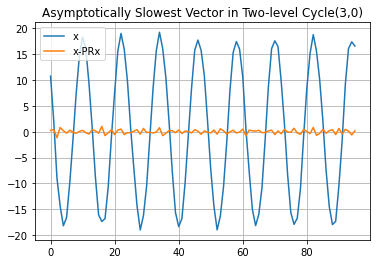

In [20]:
# TODO(orenlivne): define error as (x-x0) projected onto range(a).
nu = 3
use_r_as_restriction = True

m0 = hm.repetitive.locality.create_two_level_hierarchy_from_matrix(
    level.a, level.location, R, p, aggregate_size, num_components, use_r_as_restriction=use_r_as_restriction)

y, _ = hm.repetitive.locality.two_level_conv_factor(m0, nu, print_frequency=1, debug=False)

# Asymptotic vector.
plt.title("Asymptotically Slowest Vector in Two-level Cycle({},0)".format(nu))
y -= y.mean() # Remove zero component.
e = y - m0[1].interpolate(m0[1].coarsen(y))
plt.plot(y, label="x");
plt.plot(e, label="x-PRx");
plt.grid(True);
plt.legend();

In [21]:
# Calculate eigenpairs at all levels.
laml, vl_finest = hm.analysis.ideal.compare_spectrum(m0)
for l, lam in enumerate(laml):
    print(l, "lam", np.array2string(lam[:12], precision=3))

0 lam [-0.     0.     0.064  0.064 -0.073 -0.073  0.12   0.12  -0.154 -0.154  0.167  0.167]
1 lam [-0.    -0.     0.065  0.065 -0.073 -0.073  0.12   0.12  -0.152 -0.152  0.166  0.166]


In [22]:
m0[1].a

<48x48 sparse matrix of type '<class 'numpy.float64'>'
	with 288 stored elements in Compressed Sparse Row format>

In [23]:
pd.set_option("display.precision", 8)
pd.DataFrame(m0[0].a.todense()[2:4, :6])

,0,1,2,3,4,5
0,-0.0833,1.3333,-2.2261,1.3333,-0.0833,0.0000
1,0.0000,-0.0833,1.3333,-2.2261,1.3333,-0.0833


In [24]:
pd.set_option("display.precision", 3)
pd.DataFrame(m0[1].a.todense()[2:4, :6])

,0,1,2,3,4,5
0,0.1481,0.1699,-0.0347,0.0065,0.1495,-0.1672
1,-0.1671,-0.1531,0.0110,-0.6210,0.1729,-0.1512


In [25]:
pd.DataFrame((m0[1].a - m0[1].a.transpose()).todense()[:10, :10])

,0,1,2,3,4,5,6,7,8,9
0,0.0000,-0.0046,0.0014,-0.0002,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
1,0.0046,0.0000,0.0030,0.0019,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
2,-0.0014,-0.0030,0.0000,-0.0046,0.0014,-0.0002,0.0000,0.0000,0.0000,0.0000
3,0.0002,-0.0019,0.0046,0.0000,0.0030,0.0019,0.0000,0.0000,0.0000,0.0000
4,0.0000,0.0000,-0.0014,-0.0030,0.0000,-0.0046,0.0014,-0.0002,0.0000,0.0000
5,0.0000,0.0000,0.0002,-0.0019,0.0046,0.0000,0.0030,0.0019,0.0000,0.0000
6,0.0000,0.0000,0.0000,0.0000,-0.0014,-0.0030,0.0000,-0.0046,0.0014,-0.0002
7,0.0000,0.0000,0.0000,0.0000,0.0002,-0.0019,0.0046,0.0000,0.0030,0.0019
8,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,-0.0014,-0.0030,0.0000,-0.0046
9,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0002,-0.0019,0.0046,0.0000


<!-- #### $P^T A Q$ Coarsening
This is not exactly a matrix multiplication $P^T A Q$, since $Q$ is not a uni-valued operator. It maps a point at the edge of the stencil of $P^T A$ to two values, one when it's at the edge and one when it's in the middle of the stencil. -->

## Level 1->2 Coarsening
Are the equations at level 1 harder to solve than level 0 because of worse smoothing rates? Do we see a good coarsening ratio for an aggregate of size $4$ here too?

In [26]:
# Coarsening. Force 2 coarse vars per aggregate so we can test alignment.
aggregate_size = 4
num_components = 2

num_sweeps_on_vectors = 100

## Level 1 Relaxation

We run relaxation on $A x = 0$. $A$ has two null vectors; call $Y$ the $n \times 2$ matrix whose columns are these vectors. Let $x_0$ be a random[-1, 1] initial guess for $x$. We first project $x_0$ onto the range of $A$, that is,

$x_0 \longleftarrow x_0 - Y Y^T x_0^T\,,$

and use this as the initial guess for the run. Since the magnitude of $Y$ the exact solution is $0$, and relaxation doesn't change this magnitude, $e = x - x_0$ is a meaningful definition, which can also be used to calculate a meaningful RER.

In [27]:
m1 = m0.sub_hierarchy(1)
level = m1.finest_level
a = level.a

INFO     Kaczmarz
INFO     Iter     |r|                         |x|         RER
INFO     0     2.592e-01                    4.462e-01    0.582
INFO     1     8.598e-02 (0.331) [0.331]    2.628e-01    0.337 (0.574)
INFO     2     4.846e-02 (0.568) [0.434]    2.009e-01    0.253 (0.752)
INFO     3     2.837e-02 (0.581) [0.482]    1.740e-01    0.166 (0.674)
INFO     4     2.143e-02 (0.749) [0.539]    1.585e-01    0.136 (0.823)
INFO     5     1.686e-02 (0.779) [0.582]    1.484e-01    0.113 (0.830)
INFO     6     1.395e-02 (0.822) [0.618]    1.414e-01    0.098 (0.862)
INFO     7     1.188e-02 (0.848) [0.647]    1.360e-01    0.086 (0.880)
INFO     8     1.035e-02 (0.868) [0.672]    1.318e-01    0.078 (0.896)
INFO     9     9.186e-03 (0.884) [0.693]    1.282e-01    0.072 (0.908)
INFO     10    8.270e-03 (0.897) [0.711]    1.252e-01    0.066 (0.919)
INFO     11    7.532e-03 (0.907) [0.727]    1.226e-01    0.062 (0.927)
INFO     12    6.923e-03 (0.915) [0.742]    1.203e-01    0.059 (0.933)
INFO 

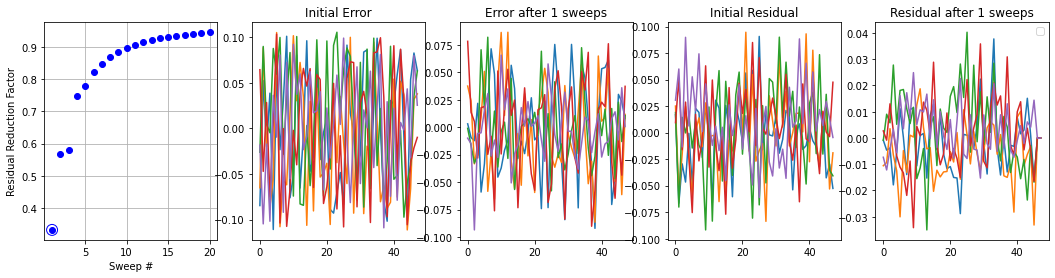

In [28]:
method_info = hm.solve.smoothing.check_relax_cycle_shrinkage(
    m1, num_levels=1, leeway_factor=leeway_factor, slow_conv_factor=0.98, max_sweeps=20)
num_sweeps = method_info["Kaczmarz"][1]

,0,1,2,3
0,0.6706,-0.2243,-0.6586,-0.2574
1,-0.4656,-0.5324,-0.4914,0.5083


nu 100 s [1.    0.802 0.004 0.   ] Energy error [0.626 0.003 0.    0.   ]
INFO     Mock cycle conv [0.326 0.175 0.138 0.097 0.105 0.052 0.073 0.051 0.037 0.031 0.029]


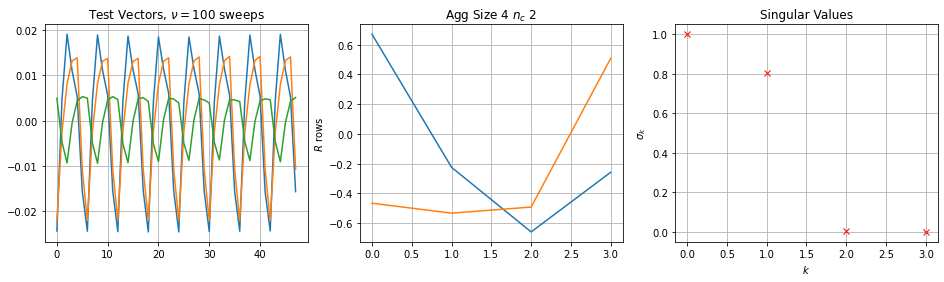

In [29]:

# #PCs revealed by relaxed vectors of increasing smoothness.
plot_svd_coarsening_accuracy(level, 100, aggregate_size, num_components)

In [30]:
pd.DataFrame(level.a.todense()[10:12, 8:14])

,0,1,2,3,4,5
0,0.1481,0.1699,-0.0347,0.0065,0.1495,-0.1672
1,-0.1671,-0.1531,0.0110,-0.6210,0.1729,-0.1512


In [31]:
ideal_tv = False # True
num_examples = 5
nu = num_sweeps_on_vectors if num_sweeps_on_vectors is not None else num_sweeps
# Generate initial test vectors.
if ideal_tv:
    _LOGGER.info("Generating {} ideal TVs".format(num_examples))
    x, lam = hm.analysis.ideal.ideal_tv(level.a, num_examples)
else:
    _LOGGER.info("Generating {} TVs with {} sweeps".format(num_examples, nu))
    x = hm.setup.auto_setup.get_test_matrix(a, nu, num_examples=num_examples)
    _LOGGER.info("RER {:.3f}".format(norm(level.a.dot(x)) / norm(x)))
x_log.append(x)

INFO     Generating 5 TVs with 100 sweeps
INFO     RER 0.001


In [32]:
#plt.plot(x[:, 0][1::2])
#plt.plot(x[:, 1][1::2])
#plt.plot(x[:, 2][1::2])

#plt.plot(x[:, 1])

In [33]:
# def autocorr(x):
#     result = np.correlate(x, x, mode='full')
#     return result[result.size//2:]

In [34]:
 # np.correlate(x[:, 0], x[:, 0], mode='full')

[1.    0.764 0.003 0.   ]
(24, 48)


,0,1,2,3,4,5,6,7,8,9
0,0.6791,-0.2143,-0.6493,-0.2669,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
1,-0.4531,-0.5363,-0.5038,0.5033,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
2,0.0000,0.0000,0.0000,0.0000,0.6791,-0.2143,-0.6493,-0.2669,0.0000,0.0000
3,0.0000,0.0000,0.0000,0.0000,-0.4531,-0.5363,-0.5038,0.5033,0.0000,0.0000
4,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.6791,-0.2143


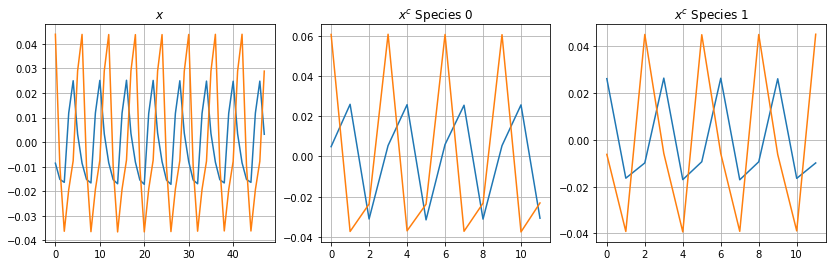

In [35]:
r, s = hm.repetitive.locality.create_coarsening(x, aggregate_size, num_components, normalize=False)
print(s/s[0])
R = r.tile(level.size // aggregate_size)
print(R.shape)
xc = R.dot(x)
display(pd.DataFrame(R[:5,:10].todense()))
hm.repetitive.locality.plot_coarsening(R, x)

### Mock Cycle Rate

In [36]:
# Calculate local mock cycle convergence rate on a domain of size 4 * aggregate_size.
m = 24
nu_values = np.arange(1, 12)
mock_conv = np.array([hm.setup.auto_setup.mock_cycle_conv_factor(level, R, nu) for nu in nu_values])
#hm.repetitive.locality.mock_conv_factor_for_domain_size(kh, discretization, r, aggregate_size, m * aggregate_size, nu_values)
_LOGGER.info("Mock cycle conv |domain|={} {}".format(
    m * aggregate_size, np.array2string(mock_conv, precision=3)))

INFO     Mock cycle conv |domain|=96 [0.331 0.197 0.141 0.127 0.105 0.088 0.073 0.059 0.029 0.039 0.03 ]


In [37]:
# hm.setup.geometry.geometric_neighbors_from_locations(location[0], location[1], n, aggregate_size)[:, :4]
# num_aggregates = int(np.ceil(multilevel[0].a.shape[0] / aggregate_size))
# num_coarse_vars = nc * num_aggregates
# np.mod(hm.setup.geometry.geometric_neighbors(aggregate_size, num_components), num_coarse_vars)

### Interpolation $P = R^T$

In [38]:
#### Initial guess for interpoation: P = R^T on a single aggregate.
p = r.tile(1).transpose()

two_level_conv = np.array([
    hm.repetitive.locality.two_level_conv_factor(
        hm.repetitive.locality.create_two_level_hierarchy_from_matrix(
            level.a, level.location, r.asarray(), p, aggregate_size, num_components), 
        nu)[1]
     for nu in nu_values])
conv = pd.DataFrame(np.array((mock_conv, two_level_conv)).transpose(), 
                    index=nu_values, columns=("Mock", "P=R^T")).transpose()

# Compare the L2 projection norm and the A*A'-orthogonal projection norms, which gives an indication
# that the mock cycle rates are guaranteed to be good predictors of the two-level rates [Rob & James].
R = r.tile(level.size // aggregate_size)
_LOGGER.info("L2 projection norm {:.2f} A*A' projection norm {:.2f}".
             format(norm(R.todense(), ord=2), norm((R.dot(level.a)).todense(), ord=2)))

INFO     L2 projection norm 1.00 A*A' projection norm 0.45


### Interpolation by LS Fitting

In [39]:
calibers = (2, 3, 4)
p_experiment = {}
l2c_experiment = {}
coarsening_values = (False, True)
titles = ("P^T A P", "R A P")
for use_r_as_restriction, title in zip(coarsening_values, titles):
    l2c = []
    p_caliber = []
    for caliber in calibers:
        p = hm.setup.auto_setup.create_interpolation(
            x, a, R, level.location, domain_size, interpolation_method, aggregate_size=aggregate_size, num_components=num_components, 
            neighborhood=neighborhood, repetitive=repetitive, target_error=0.1,
            caliber=caliber, fit_scheme=fit_scheme, weighted=weighted)
        ml = hm.repetitive.locality.create_two_level_hierarchy_from_matrix(
                level.a, level.location, R, p, aggregate_size, num_components,
                    use_r_as_restriction=use_r_as_restriction)
        ac = ml[1].a
        fill_in_factor = (ac.nnz / ml[0].a.nnz) * (ml[0].a.shape[0] / ac.shape[0])
        symmetry_deviation = np.max(np.abs(ac - ac.transpose()))
        two_level_conv = np.array([
            hm.repetitive.locality.two_level_conv_factor(
                ml, nu, print_frequency=None)[1]
             for nu in nu_values])
        l2c.append([use_r_as_restriction, caliber, p.nnz, fill_in_factor, symmetry_deviation] + list(two_level_conv))
        p_caliber.append(p)

    p_experiment[use_r_as_restriction] = p_caliber
    l2c_experiment[use_r_as_restriction] = l2c

all_conv = pd.DataFrame(np.array(
    [[np.nan] * 5 + list(row) for row in conv.values] +
    [v for use_r_as_restriction in coarsening_values for v in l2c_experiment[use_r_as_restriction]]), 
                    columns=("R A P", "Caliber", "nnz(P)", "Fill-in", "Symmetry") + tuple(nu_values), 
                        index=tuple(conv.index) + tuple("{} caliber {}".format(title, caliber) for title in titles
                          for caliber in calibers))
styler = all_conv.style.set_caption("Convergence Factors").format(precision=4)
display_html(styler._repr_html_(), raw=True)

,R A P,Caliber,nnz(P),Fill-in,Symmetry,1,2,3,4,5,6,7,8,9,10,11
Mock,nan,nan,nan,nan,nan,0.3308,0.1972,0.1411,0.1272,0.1046,0.0879,0.0728,0.0593,0.0287,0.0391,0.0303
P=R^T,nan,nan,nan,nan,nan,10.8105,6.9121,6.2625,5.2057,4.3976,3.6987,3.1055,2.6029,2.1782,1.8085,1.5278
P^T A P caliber 2,0.0000,2.0000,96.0000,1.0000,0.0021,9.1133,6.7882,6.1507,5.1136,4.3190,3.6328,3.0502,2.5565,2.1057,1.7509,1.4932
P^T A P caliber 3,0.0000,3.0000,144.0000,1.1667,0.0012,0.9742,0.6926,0.3666,0.2378,0.2143,0.1798,0.1452,0.1231,0.1068,0.0936,0.0948
P^T A P caliber 4,0.0000,4.0000,192.0000,1.6667,0.0004,1.8037,0.8930,0.3440,0.1827,0.0957,0.0756,0.0682,0.0666,0.0548,0.0425,0.0357
R A P caliber 2,1.0000,2.0000,96.0000,1.0000,0.0020,10.6891,6.8481,6.2024,5.1580,4.3565,3.6644,3.0767,2.5787,2.1506,1.7964,1.5120
R A P caliber 3,1.0000,3.0000,144.0000,1.0000,0.0012,1.7072,1.6545,1.0932,0.6865,0.6117,0.4967,0.3682,0.3314,0.3149,0.2740,0.2614
R A P caliber 4,1.0000,4.0000,192.0000,1.0000,0.0285,3.0585,1.5927,0.5058,0.1543,0.0741,0.0764,0.0483,0.0533,0.0471,0.0453,0.0391


### Solving $Ax = b$ - Convergence History

INFO         0 |r| 2.361e+00 RER 0.62312
INFO         1 |r| 1.319e-01 (0.05586) RER 0.03372 (0.05412) 3.911
INFO         2 |r| 6.244e-03 (0.04735) RER 0.00161 (0.04761) 3.889
INFO         3 |r| 4.183e-04 (0.06699) RER 0.00011 (0.06685) 3.897
INFO         4 |r| 4.324e-05 (0.10338) RER 0.00001 (0.10337) 3.898
INFO         5 |r| 4.536e-06 (0.10491) RER 0.00000 (0.10491) 3.898
INFO         6 |r| 2.962e-07 (0.06530) RER 0.00000 (0.06530) 3.898
INFO         7 |r| 1.464e-08 (0.04944) RER 0.00000 (0.04944) 3.898
INFO         8 |r| 1.184e-09 (0.08085) RER 0.00000 (0.08085) 3.898
INFO         9 |r| 1.185e-10 (0.10006) RER 0.00000 (0.10006) 3.898
INFO        10 |r| 8.691e-12 (0.07335) RER 0.00000 (0.07335) 3.898


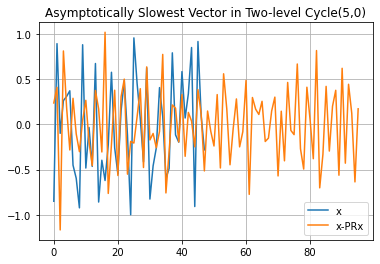

In [40]:
# TODO(orenlivne): define error as (x-x0) projected onto range(a).
nu = 5
p = p_experiment[True][-1]  # P^T*A*P P high order
use_r_as_restriction = True

m1 = hm.repetitive.locality.create_two_level_hierarchy_from_matrix(
    level.a, level.location, R, p, aggregate_size, num_components, use_r_as_restriction=use_r_as_restriction)

y, _ = hm.repetitive.locality.two_level_conv_factor(m1, nu, print_frequency=1,
                                                    debug=False)

# Asymptotic vector.
plt.title("Asymptotically Slowest Vector in Two-level Cycle({},0)".format(nu))
# y -= y.mean() # Remove zero component.
# e = y - multilevel[1].p.dot(multilevel[1].r.dot(y))
plt.plot(y, label="x");
plt.plot(e, label="x-PRx");
plt.grid(True);
plt.legend();

In [41]:
pd.DataFrame(m1[1]._r.todense()[:2, :4])

,0,1,2,3
0,0.6791,-0.2143,-0.6493,-0.2669
1,-0.4531,-0.5363,-0.5038,0.5033


In [42]:
# Calculate eigenpairs at all levels.
laml, vl_finest = hm.analysis.ideal.compare_spectrum(m1)
for l, lam in enumerate(laml):
    print(l, "lam", lam[:12])

0 lam [-0.    -0.     0.065  0.065 -0.073 -0.073  0.12   0.12  -0.152 -0.152  0.166  0.166]
1 lam [-0.    -0.    -0.001 -0.001 -0.042 -0.042  0.054  0.054  0.056  0.056 -0.056 -0.076]


## 3-Level Method

In [43]:
m0.add(m1[1])

INFO         0 |r| 1.833e+01 RER 3.32142
INFO         1 |r| 8.078e-01 (0.04406) RER 0.02572 (0.00774) 31.406
INFO         2 |r| 7.905e-02 (0.09786) RER 0.00234 (0.09117) 33.709
INFO         3 |r| 8.010e-03 (0.10134) RER 0.00024 (0.10110) 33.786
INFO         4 |r| 9.402e-04 (0.11737) RER 0.00003 (0.11736) 33.788
INFO         5 |r| 1.163e-04 (0.12369) RER 0.00000 (0.12368) 33.789
INFO         6 |r| 1.384e-05 (0.11904) RER 0.00000 (0.11904) 33.789
INFO         7 |r| 1.598e-06 (0.11544) RER 0.00000 (0.11544) 33.789
INFO         8 |r| 1.817e-07 (0.11368) RER 0.00000 (0.11368) 33.789
INFO         9 |r| 2.230e-08 (0.12274) RER 0.00000 (0.12274) 33.789
INFO        10 |r| 2.900e-09 (0.13009) RER 0.00000 (0.13009) 33.789
INFO        11 |r| 3.774e-10 (0.13011) RER 0.00000 (0.13011) 33.789
INFO        12 |r| 4.896e-11 (0.12974) RER 0.00000 (0.12974) 33.789


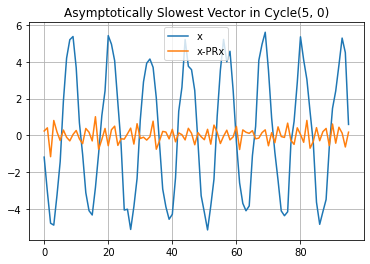

In [44]:
nu_pre = 5
nu_post = 2
y, _ = hm.repetitive.locality.two_level_conv_factor(m0, nu_pre, nu_post=nu_post, print_frequency=1, debug=False)

# Asymptotic vector.
plt.title("Asymptotically Slowest Vector in Cycle({}, 0)".format(nu_pre, nu_post))
# y -= y.mean() # Remove zero component.
# e = y - multilevel[1].p.dot(multilevel[1].r.dot(y))
plt.plot(y, label="x");
plt.plot(e, label="x-PRx");
plt.grid(True);
plt.legend();

In [45]:
# Calculate eigenpairs at all levels.
laml, vl_finest = hm.analysis.ideal.compare_spectrum(m0)
for l, lam in enumerate(laml):
    print(l, "lam", lam[:12])

0 lam [-0.     0.     0.064  0.064 -0.073 -0.073  0.12   0.12  -0.154 -0.154  0.167  0.167]
1 lam [-0.    -0.     0.065  0.065 -0.073 -0.073  0.12   0.12  -0.152 -0.152  0.166  0.166]
2 lam [-0.    -0.    -0.001 -0.001 -0.042 -0.042  0.054  0.054  0.056  0.056 -0.056 -0.076]


In [46]:
# Save A^1 to file.
#scipy.sparse.save_npz('level_1_operator.npz', m0[1].a)

## What are the Coarse Variables?
Given level $l$ and some point $i$,  we look at $P^l P^{l-1} ... P^1 e^l_i$ wheer $e^l_i$ is the $i$th unit vector. There are two species ($i, i+1$) in our setup (4/2 coarsening at all levels). The following matix is level x species.

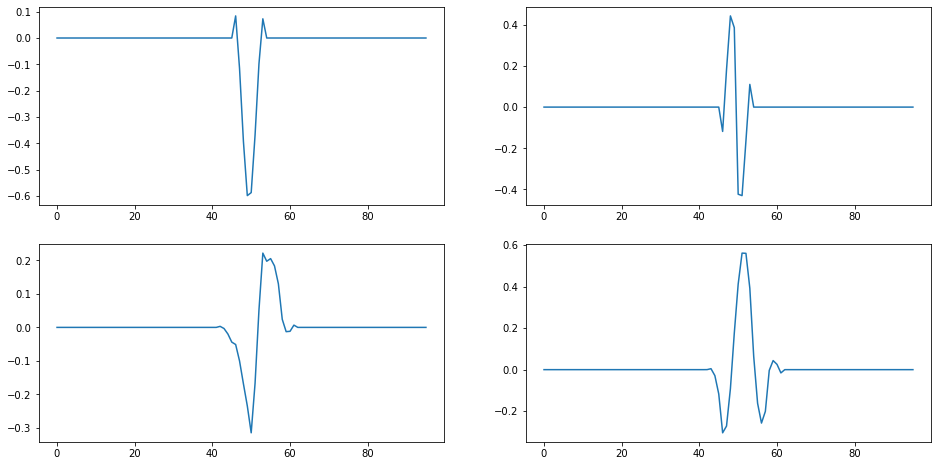

In [47]:
fig, axs = plt.subplots(len(m0) - 1, num_components, figsize=(16, 8))

for l in range(1, len(m0)):
    m = m0[l].size
    i = m // 2
    for col, j in enumerate(range(i, i + num_components)):
        u = np.zeros((m,))
        u[j] = 1
        for ll in range(l, 0, -1):
            u = m0[ll]._p.dot(u)
        axs[l - 1, col].plot(u);

## Symmetrizing $R A P$: Level 0->1

In [78]:
level, coarse_level = m0[:2]

### First experiment: $R -> Q$, $P$ stays fixed
$A^c = QAP$ is symmetric and sparse, but not accurate since $P$ is incompatible with $Q$, so 2-level convergence not that great. Even the first few cycles are slow (maybe the first cycle is OK, but that's it).

In [83]:
r = coarse_level._r
p = coarse_level._p
ap = level.a.dot(p)
q = hm.repetitive.symmetry.symmetrize(r, ap, num_components, aggregate_size)
nu = 5
print("nu", nu)
for title, restriction in (("r", r), ("q", q)):
    print("Restriction", title)
    ml = hm.repetitive.locality.create_two_level_hierarchy_from_matrix(
        level.a, level.location, restriction, p, aggregate_size, num_components, use_r_as_restriction=True)
    ac = ml[1].a
    display(pd.DataFrame(ac.todense()[2:4, :6]))
    display(pd.DataFrame((ac - ac.T).todense()[2:4, :6]))
    y, _ = hm.repetitive.locality.two_level_conv_factor(ml, nu, print_frequency=1, debug=False)

nu 5
Restriction r


,0,1,2,3,4,5
0,0.1481,0.1699,-0.0347,0.0065,0.1495,-0.1672
1,-0.1671,-0.1531,0.0110,-0.6210,0.1729,-0.1512


,0,1,2,3,4,5
0,-0.0014,-0.0030,0.0000,-0.0046,0.0014,-0.0002
1,0.0002,-0.0019,0.0046,0.0000,0.0030,0.0019


INFO         0 |r| 1.759e+01 RER 2.93641
INFO         1 |r| 2.235e+00 (0.12706) RER 0.06284 (0.02140) 35.561
INFO         2 |r| 2.664e-01 (0.11922) RER 0.00779 (0.12394) 34.207
INFO         3 |r| 4.137e-02 (0.15525) RER 0.00121 (0.15580) 34.088
INFO         4 |r| 8.090e-03 (0.19558) RER 0.00024 (0.19531) 34.134
INFO         5 |r| 1.423e-03 (0.17586) RER 0.00004 (0.17596) 34.117
INFO         6 |r| 2.872e-04 (0.20183) RER 0.00001 (0.20182) 34.119
INFO         7 |r| 5.776e-05 (0.20115) RER 0.00000 (0.20115) 34.119
INFO         8 |r| 1.205e-05 (0.20860) RER 0.00000 (0.20860) 34.119
INFO         9 |r| 2.571e-06 (0.21337) RER 0.00000 (0.21337) 34.119
INFO        10 |r| 5.517e-07 (0.21461) RER 0.00000 (0.21461) 34.119
INFO        11 |r| 1.170e-07 (0.21202) RER 0.00000 (0.21202) 34.119
INFO        12 |r| 2.502e-08 (0.21384) RER 0.00000 (0.21384) 34.119
INFO        13 |r| 5.361e-09 (0.21430) RER 0.00000 (0.21430) 34.119
INFO        14 |r| 1.150e-09 (0.21459) RER 0.00000 (0.21459) 34.119
INFO   

,0,1,2,3,4,5
0,0.1508,0.1724,-0.0340,0.0098,0.1508,-0.1670
1,-0.1670,-0.1538,0.0098,-0.6215,0.1724,-0.1538


,0,1,2,3,4,5
0,-0.0000,-0.0000,0.0000,-0.0000,0.0000,0.0000
1,-0.0000,0.0000,0.0000,0.0000,0.0000,0.0000


INFO         0 |r| 1.862e+01 RER 3.24064
INFO         1 |r| 2.408e+00 (0.12933) RER 0.03424 (0.01057) 70.309
INFO         2 |r| 1.189e+00 (0.49404) RER 0.02617 (0.76421) 45.452
INFO         3 |r| 7.885e-01 (0.66296) RER 0.02130 (0.81376) 37.029
INFO         4 |r| 6.015e-01 (0.76282) RER 0.01114 (0.52316) 53.992
INFO         5 |r| 4.691e-01 (0.77994) RER 0.01492 (1.33941) 31.439
INFO         6 |r| 3.494e-01 (0.74471) RER 0.00715 (0.47946) 48.833
INFO         7 |r| 2.437e-01 (0.69743) RER 0.00628 (0.87738) 38.817
INFO         8 |r| 1.643e-01 (0.67418) RER 0.00388 (0.61806) 42.342
INFO         9 |r| 1.154e-01 (0.70273) RER 0.00268 (0.69064) 43.083
INFO        10 |r| 8.799e-02 (0.76218) RER 0.00219 (0.81862) 40.113
INFO        11 |r| 6.857e-02 (0.77936) RER 0.00158 (0.72132) 43.340
INFO        12 |r| 5.103e-02 (0.74413) RER 0.00125 (0.79022) 40.812
INFO        13 |r| 3.556e-02 (0.69693) RER 0.00084 (0.67266) 42.285
INFO        14 |r| 2.398e-02 (0.67418) RER 0.00057 (0.68253) 41.768
INFO   

In [121]:
r = coarse_level._r
p = coarse_level._p
ap = level.a.dot(p)
q = hm.repetitive.symmetry.symmetrize(r, ap, num_components, aggregate_size)

l2c = []
for title, restriction in (("r", r), ("q", q)):
    #print("Restriction", title)
    ml = hm.repetitive.locality.create_two_level_hierarchy_from_matrix(
        level.a, level.location, restriction, p, aggregate_size, num_components, use_r_as_restriction=True)
    ac = ml[1].a
    fill_in_factor = (ac.nnz / ml[0].a.nnz) * (ml[0].a.shape[0] / ac.shape[0])
    symmetry_deviation = np.max(np.abs(ac - ac.transpose()))
    two_level_result = [
        hm.repetitive.locality.two_level_conv_factor(
            ml, nu, print_frequency=None, debug=False)
         for nu in nu_values]
    two_level_conv = np.array([row[1] for row in two_level_result])
    l2c.append([use_r_as_restriction, caliber, p.nnz, fill_in_factor, symmetry_deviation] + list(two_level_conv))

l2c = all_conv0.loc[["Mock"]].values.tolist() + l2c

print(len(l2c))
all_conv = pd.DataFrame(l2c,
                    columns=("R A P", "Caliber", "nnz(P)", "Fill-in", "Symmetry") + tuple(nu_values), 
                        index=("Mock",) + tuple(titles))
styler = all_conv.style.set_caption("Convergence Factors").format(precision=4)
display_html(styler._repr_html_(), raw=True)

3


,R A P,Caliber,nnz(P),Fill-in,Symmetry,1,2,3,4,5,6,7,8
Mock,nan,nan,nan,nan,nan,0.5889,0.2939,0.1670,0.1099,0.1501,0.1153,0.0824,0.0634
r,True,4.0000,384.0000,1.2000,0.0046,1.9996,0.5636,0.5414,0.2145,0.2069,0.1644,0.1043,0.0959
q,True,4.0000,384.0000,1.2000,0.0000,8.3507,0.6291,1.9590,0.6326,0.7183,0.5714,0.4399,0.1829


<!-- ### Self-Consistent Iteration
Start from $Q = R$, fit $P$ to $x \approx P Q x$ for TFs x,then update $Q$ by Kaczmarz, refit $P$, etc. -->

In [81]:
# def update_interpolation(x, r, caliber, num_windows):
#     conv = [[np.nan] + [
#         hm.setup.auto_setup.mock_cycle_conv_factor(level, r, nu) 
#         for nu in nu_values]]
#     p = hm.setup.auto_setup.create_interpolation(
#             x, level.a, r, level.location, domain_size, interpolation_method, aggregate_size=aggregate_size, num_components=num_components, 
#             neighborhood=neighborhood, repetitive=repetitive, target_error=0.1,
#             caliber=caliber, fit_scheme=fit_scheme, weighted=weighted)
#     ml = hm.repetitive.locality.create_two_level_hierarchy_from_matrix(
#             level.a, level.location, r, p, aggregate_size, num_components,
#                 use_r_as_restriction=True)
#     ac = ml[1].a
#     fill_in_factor = (ac.nnz / ml[0].a.nnz) * (ml[0].a.shape[0] / ac.shape[0])
#     symmetry_deviation = np.max(np.abs(ac - ac.transpose()))
#     two_level_conv = [
#         hm.repetitive.locality.two_level_conv_factor(ml, nu, print_frequency=None)[1] 
#         for nu in nu_values]
#     conv.append([symmetry_deviation] + two_level_conv)
#     return ml, conv

# caliber = 4
# num_examples = 4
# num_windows = 32
# num_iterations = 10
# x = hm.setup.auto_setup.get_test_matrix(level.a, num_sweeps_on_vectors, num_examples=num_examples)

# all_conv = []
# r = coarse_level._r
# ml, conv = update_interpolation(x, r, caliber, num_windows)
# p = ml[1]._p
# all_conv += conv
# for i in range(num_iterations):
#     r = symmetrize(r, level.a.dot(p), num_components, aggregate_size)
#     ml, conv = update_interpolation(x, r, caliber, num_windows)
#     p = ml[1]._p
#     all_conv += conv

# all_conv = pd.DataFrame(all_conv,
#                     columns=("Symmetry",) + tuple(nu_values), 
#                     index=sum((("{} Mock".format(i), "{} 2L".format(i))
#                         for i in range(num_iterations + 1)), ()))
# styler = all_conv.style.set_caption("Convergence Factors").format(precision=4)
# display_html(styler._repr_html_(), raw=True)

In [ ]:
ac = ml[1].a
pd.DataFrame(ac.todense()[2:4, :6])
#pd.DataFrame((ac - ac.T).todense()[2:4, :6])

In [ ]:
np.max(np.abs(ac - ac.transpose()))

The self-consistent iteration reduced the symmetry deviation but not by much and did not converge to a symmetric solution.

## Stencils

### R

In [ ]:
pd.DataFrame(ml[1]._r[:2, :4].todense())

### P

In [ ]:
pd.DataFrame(ml[1]._p[6:10, 2:6].todense())

### R A P

In [ ]:
pd.DataFrame(ml[1]._r.dot(ml[0].a).dot(ml[1]._p)[4:6, 2:8].todense())